## 2.2 Monte Carlo simulation of DLA

DLA can also be simulated by releasing random walkers on a grid, and letting them
walk until they hit the cluster. When they hit, the walkers are stopped and become
part of the cluster.
One random walker at a time is released in the system. It moves in steps, which
are randomly chosen to be one lattice point up, down, left, or right. If the walker
reaches a cell neighboring the cluster, the walker is stopped there, so that the cell
with the walker becomes part of the cluster.
To simulate with the same boundary conditions as above, start the walkers on a
randomly chosen point on the top boundary. If a walker walks out of the system
on the top or bottom boundary it is removed and a new one created instead. If it
walks across the left or right boundary, it should enter the system from the other
side, as periodic boundary conditions were assumed in the horizontal direction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from numba import njit
from numba.typed import List
from numba.np import random as nbrandom
import concurrent.futures
from itertools import accumulate

plt.rcParams.update({'font.size': 14})

### **B**. (2 points) 
Implement the Monte Carlo version of DLA. Compare the resulting 
cluster to those obtained with the diffusion equation.

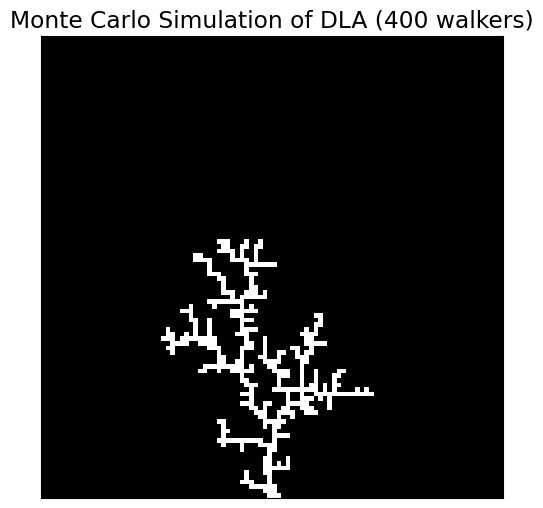

In [2]:
def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    grid[size // 2, 0] = 1  # initial atom in the middle of the bottom row
    return grid

def move_walker(x, y, size):
    direction = random.choice([(0, 1), (0, -1), (1, 0), (-1, 0)])  # 只允许上下左右移动
    x_new, y_new = x + direction[0], y + direction[1]
    # wrap around at the edges
    x_new = x_new % size
    return x_new, y_new

def is_adjacent(x, y, grid, size):
    return ((x > 0 and grid[x - 1, y] == 1) or
            (x < size - 1 and grid[x + 1, y] == 1) or
            (y > 0 and grid[x, y - 1] == 1) or
            (y < size - 1 and grid[x, y + 1] == 1))

def simulate_dla(size=100, num_walkers=400):
    grid = initialize_grid(size)
    current_walkers = 0
    while current_walkers < num_walkers:
        x, y = random.randint(0, size - 1), size - 1
        while True:
            x, y = move_walker(x, y, size)
            if y < 0 or y >= size:
                break  # remove walker if it falls off the grid
            if is_adjacent(x, y, grid, size):
                grid[x, y] = 1 
                current_walkers += 1
                break
    return grid

# run simulation
size = 100
dla_grid = simulate_dla(size, num_walkers=400)
plt.figure(figsize=(6, 6))
plt.imshow(dla_grid.T, cmap='gray', origin='lower')
plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.title("Monte Carlo Simulation of DLA (400 walkers)")
plt.show()

- The resulting clusters obtained with the Monte Carlo DLA simulation exhibit a fractal-like structure with some hollow regions. 

- These hollow spaces arise due to the stochastic nature of the random walkers, as they may not fully explore all possible growth areas. 

- Unlike the diffusion equation, which results in a smooth density distribution, DLA leads to an irregular and sparse aggregation pattern.

### **C**. (1 point)
In this model, the $\eta$ parameter is no longer easily variable; it is fixed to 1.  However, another parameter can be introduced, namely a sticking probability $p_s$.  The sticking rule can then be stated in the following way:  if the walker enters a cell that is a neighbor of the cluster, it stops there with probability $p_s$.  If it does not stick, the walk continues as normal.  The walker is, however, not allowed to move into a site belonging to the cluster.  Run the simulation for different values of $p_s$, and plot the results.  How does the cluster shape depend on $p_s$ ?

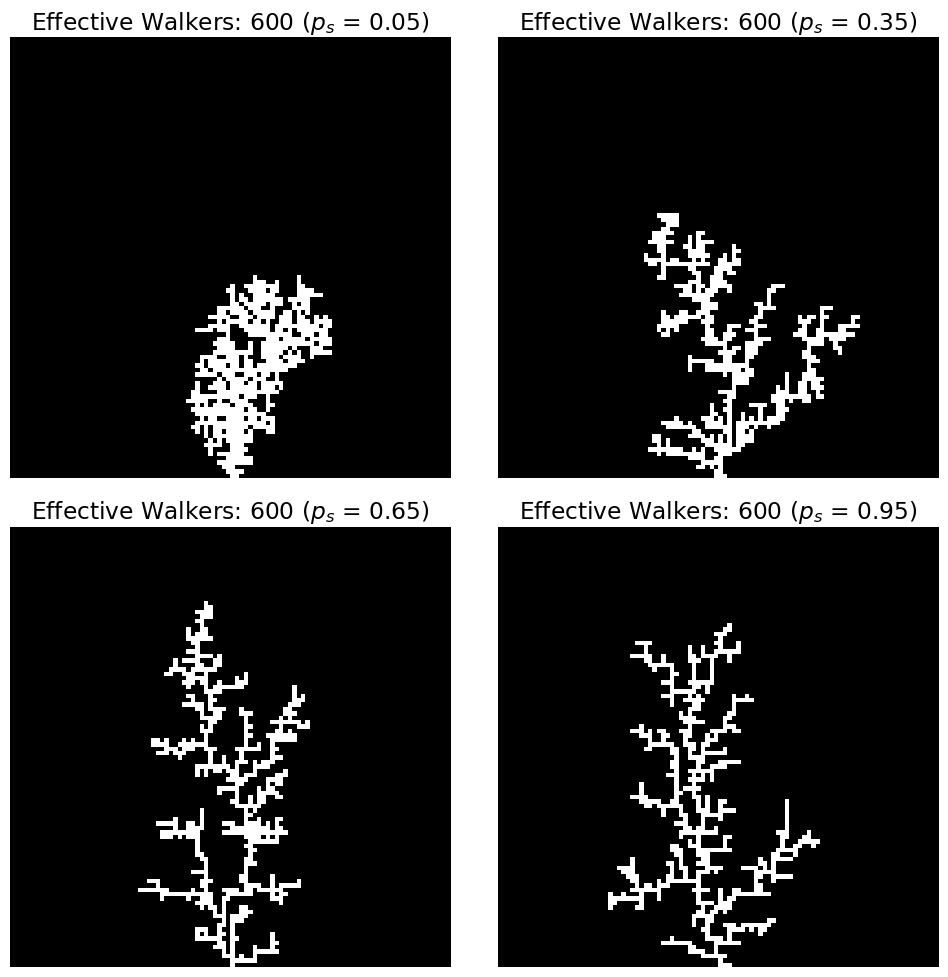

In [3]:
@njit
def move_walker(x, y):
    moves = [(0, 1), (0, -1), (-1, 0), (1, 0)]  # only allow up, down, left, right
    dx, dy = moves[np.random.randint(0, 4)]
    return x + dx, y + dy

@njit
def is_adjacent(x, y, grid, size, p_s):
    neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
    for i, j in neighbors:
        if 0 <= i < size and 0 <= j < size and grid[i, j] == 1:
            if np.random.rand() < p_s:  # stop with probability p_s
                return True
    return False

def simulate_dla(size=100, num_walkers=600, p_s=1.0):
    grid = np.zeros((size, size), dtype=int)
    grid[size // 2, 0] = 1  # initial cluster at the bottom
    current_walkers = 0
    while current_walkers < num_walkers:
        x, y = np.random.randint(0, size), size - 1  # free a random walker from the top
        while True:
            try_x, try_y = move_walker(x, y)
            try_x = try_x % size
            if try_y < 0 or try_y >= size:
                break
            if grid[try_x, try_y]:  
                continue
            x, y = try_x, try_y 
            if is_adjacent(x, y, grid, size, p_s):  
                grid[x, y] = 1 
                current_walkers += 1
                break
    return grid

size = 100
p_values = [0.05, 0.35, 0.65, 0.95]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 grid
axes = axes.flatten()
for i, p_s in enumerate(p_values):
    dla_grid = simulate_dla(size, num_walkers=600, p_s=p_s)
    axes[i].imshow(dla_grid.T, cmap='gray', origin='lower')
    axes[i].set_title(f"Effective Walkers: 600 ($p_s$ = {p_s})")
    axes[i].axis('off')
plt.tight_layout()
plt.show()



In question C, a lower $p_s$ allows the walker to keep moving, while a higher $p_s$ results in faster attachment.

The experiment tests four cases: $p_s = 0.05, 0.35, 0.65, 0.95$. The results show that lower $p_s$ produces sparser and more elongated aggregates, whereas higher $p_s$ leads to denser and more branched structures.

This behavior resembles real-world particle deposition and growth processes. For example, low $p_s$ simulates weak adhesion environments (such as diffusion-limited deposition), while high $p_s$ is more similar to ice crystal growth, electrochemical deposition, or other high-adhesion systems.

In conclusion, lower $p_s$ results in a more sparse DLA structure, while higher $p_s$ makes it denser, aligning with the physical properties of the DLA model.
